In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125
import seaborn as sns
from Bio import SeqIO, Seq
import scipy.stats as st
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import glob, os, sys, yaml, subprocess, itertools, sparse

who_variants_combined = pd.read_csv("who_confidence_2021.csv")
drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")
samples_summary = pd.read_csv("../data/samples_summary.csv")
snp_scheme = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
snp_scheme["#lineage"] = snp_scheme["#lineage"].str.replace("lineage", "")
snp_scheme.rename(columns={"#lineage": "Lineage"}, inplace=True)

lineages = pd.read_csv("../data/combined_lineages_samples.csv", low_memory=False)

import warnings
warnings.filterwarnings(action='ignore')

# utils files are in a separate folder
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *
from data_utils import *

# CHANGE ANALYSIS DIR BEFORE RUNNING THE NOTEBOOK!
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

In [9]:
drugs_lst = os.listdir(analysis_dir)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

# Write Final Dataframes for the Binary Analysis to an Excel File

Each drug will have a separate Excel file. Each file will have 16 sheets, one for each model.

For INH, surprising that hadA variants are found with high associations. Might be homoplastic!
For PZA, surprising that clpC1_c.2302T>C co-occurs with pncA_p.His57Asp

In [10]:
def get_unpooled_table_by_tier(drug, phenos_name, tiers_lst, folder="BINARY", model_prefix="dropAF_noSyn_unpooled"):
    
    ################## 1. READ IN RIDGE REGRESSION RESULTS ##################
    model_permute = pd.read_csv(os.path.join(f"{analysis_dir}/{drug}/{folder}/tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/model_analysis.csv")).query("~mutation.str.contains('PC')")
    
    # remove the tier 1 genes for the purposes of this analysis
    if len(tiers_lst) == 2:
        model1_permute = pd.read_csv(os.path.join(f"{analysis_dir}/{drug}/{folder}/tiers=1/phenos={phenos_name}/{model_prefix}/model_analysis.csv")).query("~mutation.str.contains('PC')")
        model_permute = model_permute.query("mutation not in @model1_permute.mutation")

    ################## 2. READ IN LRT RESULTS ##################
    LRTresults = pd.read_csv(os.path.join(f"{analysis_dir}/{drug}/{folder}/tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/LRT_results.csv"))
    LRTresults.rename(columns={LRTresults.columns[0]: "mutation"}, inplace=True)

    # add neutral p-value, which is 1 - LRT p-value
    # remove the FULL model row, which is the first row
    LRTresults["neutral_pval"] = 1 - LRTresults["pval"]
    LRTresults = add_pval_corrections(LRTresults.iloc[1:, ])
    
    # check that all mutations in the permutation dataframe are in the LRT dataframe. The only difference should be the FULL model row
    assert len(set(model_permute["mutation"]).symmetric_difference(LRTresults["mutation"])) == 0

    # combine results into a single dataframe for easy searching. REMOVE BONFERRONI AND COEFS
    model = model_permute[model_permute.columns[~model_permute.columns.str.contains("|".join(["Bonferroni", "coef"]))]].merge(LRTresults[["mutation", "pval", "BH_pval", "neutral_pval", "neutral_BH_pval"]].rename(columns={"pval": "LRT_pval", 
                                                                                                                   "BH_pval": "LRT_BH_pval"
                                                                                                                  }), on="mutation", how="left")

    ################## 3. READ IN AUC TEST RESULTS ##################
    if os.path.isfile(os.path.join(analysis_dir, drug, folder, f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/AUC_test_results.csv")):
        
        auc_test = pd.read_csv(os.path.join(analysis_dir, drug, folder, f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/AUC_test_results.csv"))
        del auc_test["Bonferroni_pval"]

        combined_results = model.merge(auc_test.rename(columns={"pval": "AUC_pval", "BH_pval": "AUC_BH_pval"}), 
                          on="mutation", how="left")
                
    else:
        combined_results = model.copy()

        combined_results[['Num_Isolates',
               "Mut_R", "Mut_S", "NoMut_S", "NoMut_R"]] = combined_results[['Num_Isolates',
               "Mut_R", "Mut_S", "NoMut_S", "NoMut_R"]].astype(int)
        
    combined_results["Tier"] = tiers_lst[-1]

    # columns to return, in the desired order
    keep_cols = ['mutation', 'Tier', 'predicted_effect', 'position', 'confidence', 'Odds_Ratio',
                           'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval', 'LRT_BH_pval', 'neutral_pval', 'neutral_BH_pval']

    if "AUC_BH_pval" in combined_results.columns:
        keep_cols += ['AUC_pval', 'AUC_BH_pval']

    keep_cols += ['Num_Isolates', "Mut_R", "Mut_S", "NoMut_S", "NoMut_R", 
                  'PPV', 'NPV', 'Sens', 'Spec', 'LR+', 'LR-',
                   'PPV_LB', 'PPV_UB', 'NPV_LB', 'NPV_UB', 'Sens_LB', 'Sens_UB', 'Spec_LB',
                   'Spec_UB', 'LR+_LB', 'LR+_UB', 'LR-_LB', 'LR-_UB'
                   ]
    
    # check that AUC values are null ONLY for mutations that were not significant in Ridge and LRT
    if "AUC_BH_pval" in combined_results.columns:
        
        if len(tiers_lst) == 1:
            thresh = 0.05
        else:
            thresh = 0.01
        
        # mutations that are significant should NOT be null in the AUC_BH_pval column
        assert len(combined_results.loc[(combined_results["BH_pval"] < thresh) & 
                                        (combined_results["LRT_BH_pval"] < thresh) &
                                        (pd.isnull(combined_results["AUC_BH_pval"]))]
                  ) == 0
        
        # mutations that are NOT significant should ALL be null in the AUC_BH_pval column
        assert len(combined_results.loc[(~(combined_results["BH_pval"] < thresh) & 
                                            (combined_results["LRT_BH_pval"] < thresh)) &
                                        (~pd.isnull(combined_results["AUC_BH_pval"]))]
                  ) == 0

    return combined_results[keep_cols]

In [11]:
def add_significance_category(df, tiers_lst):
    '''
    Add significance category annotations, in the form of integers. Add the ones with the fewest requirements first, and then progressively add
    '''
    
    col_name = "regression_confidence"
    
    # add significant column
    if len(tiers_lst) == 1:
        thresh = 0.05
    else:
        thresh = 0.01
    
    # uncertain = significant coefficient, but it could be positive or negative
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] > 1), col_name] = "Possible Assoc w R"
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] < 1), col_name] = "Possible Assoc w S"
    
    df.loc[(df[col_name] == "Possible Assoc w R") & 
           (df["LRT_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5) & (df["PPV_LB"] >= 0.25), col_name] = "Assoc w R - strict"
    
    df.loc[(df[col_name] == "Possible Assoc w S") & 
           (df["LRT_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5) & (df["NPV_LB"] >= 0.25), col_name] = "Assoc w S - strict"
    
    # neutral mutations: not significant in regression AND significant in the neutral LRT test AND present at high enough frequency
    df.loc[(df["BH_pval"] >= thresh) & (df["neutral_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5), col_name] = "Neutral"

    if "AUC_BH_pval" in df.columns:
    
        # only mutations that were significant in both Ridge and LRT were tested in the AUC test, so that signifiance group must be one of the associated with resistance
        df.loc[(df[col_name].isin(["Assoc w R - strict", "Assoc w S - strict", "Possible Assoc w R", "Possible Assoc w S"])) & (df["AUC_BH_pval"] < thresh), "High_Predictive_Value"] = 1
                
        # fill remainder with 0s
        df["High_Predictive_Value"] = df["High_Predictive_Value"].fillna(0)
    
    # entire column will be 0
    else:
        df["High_Predictive_Value"] = 0
        
    # ALSO REPLACE THE UPPER OR LOWER BOUND OF THE ODDS RATIO WITH 1, DEPENDING ON THE DIRECTION
    df = df.reset_index(drop=True)
    
    for i, row in df.iterrows():
        if row[col_name] == 'Assoc w R - strict':
            if row["OR_LB"] < 1:
                df.loc[i, "OR_LB"] = 1
        elif row[col_name] == 'Assoc w S - strict':
            if row["OR_UB"] > 1:
                df.loc[i, "OR_UB"] = 1

    df[col_name] = df[col_name].fillna("Uncertain")
    return df

In [12]:
def add_single_lineage_annotations_to_model(drug, df, folder, model_path):
    '''
    Annotate mutations that are present in a single lineage. Basically just a flag when performing further analyses.
    
    It's done at the lowest level because that's the output of Coll2014. So it will not flag mutations that are all present in L2, unless L2 was the deepest category fast-lineage-caller identified.
    '''
    
    model_matrix = pd.read_pickle(os.path.join(analysis_dir, drug, folder, model_path, "model_matrix.pkl"))

    lineages_single_model = lineages.query("~Coll2014.str.contains(',')").rename(columns={"Coll2014": "Lineage"})
    model_matrix = model_matrix.loc[model_matrix.index.isin(lineages_single_model['sample_id'].values)]
    model_matrix = model_matrix.merge(lineages_single_model[["Lineage", "sample_id"]], left_index=True, right_on="sample_id")
    
    single_lineage_mutations = {}

    for col in model_matrix.columns:

        if col not in ["sample_id", "Lineage"]:

            mutation_lineages = model_matrix.loc[model_matrix[col]==1]["Lineage"].unique()

            # there is only one lineage present
            if len(mutation_lineages) == 1:
                single_lineage_mutations[col] = mutation_lineages[0]
    
    # add lineage annotations to dataframe. Only mutations that are in the model matrix are in this dictionary
    df["single_lineage"] = df["mutation"].map(single_lineage_mutations)
    return df

In [15]:
def export_binary_analyses(drugs_lst, folder, analyses_lst):
    
    if not os.path.isdir(f"../results/{folder}"):
        os.mkdir(f"../results/{folder}")
    
    for drug in np.sort(drugs_lst):
        
        all_analyses = {}

        for i, model_path in enumerate(analyses_lst):
            # some may not be there. Usually this is Pretomanid because there are no tier 2 genes or WHO phenotypes
            if os.path.isfile(os.path.join(analysis_dir, drug, folder, model_path, "model_matrix.pkl")):
                
                tiers_lst = [["1", "2"] if "1+2" in model_path else ["1"]][0]
                
                if "dropAF_noSyn_unpooled" in model_path:
                    phenos_name = ["ALL" if "ALL" in model_path else "WHO"][0]
                    add_analysis = get_unpooled_table_by_tier(drug, phenos_name, tiers_lst, folder, model_prefix="dropAF_noSyn_unpooled")
                    add_analysis = add_significance_category(add_analysis, tiers_lst)
                    
                    # add annotation denoting whether a mutation is only present in a single lineage
                    add_analysis = add_single_lineage_annotations_to_model(drug, add_analysis, folder, model_path)
                    
                    # check that high predictive value is reserved only for Assoc w R/S - strict categories
                    assert len(add_analysis.loc[(add_analysis["High_Predictive_Value"]==1) & (~add_analysis["regression_confidence"].isin(['Assoc w R - strict', 'Assoc w S - strict', 'Possible Assoc w R', 'Possible Assoc w S']))]) == 0
                else:
                    add_analysis = pd.read_csv(os.path.join(analysis_dir, drug, folder, model_path, "model_analysis.csv"))[['mutation', 'predicted_effect', 'position', 'confidence', 'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval']].query("~mutation.str.contains('PC')")
                    add_analysis = pd.read_csv(os.path.join(analysis_dir, drug, folder, model_path, "model_analysis.csv")).query("~mutation.str.contains('PC')")
                    
                    # only going to assess significance on the unpooled mutations models, so only keep these columns
                    add_analysis = add_analysis[['mutation', 'predicted_effect', 'position', 'confidence',
                                                 'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval'
                                                ]]
                    add_analysis["Tier"] = [2 if "+2" in model_path else 1][0]

                # the phenotype category is only relevant for the binary analysis
                if folder == "BINARY":
                    add_analysis["Phenos"] = ["ALL" if "phenos=ALL" in model_path else "WHO"][0]

                add_analysis["pool_type"] = model_path.split("_")[-1]
                add_analysis["synonymous"] = int("withSyn" in model_path)
                #add_analysis["HET"] = ["DROP" if "drop" in model_path else "AF"][0]
                
                # do this here if you want to include significance categories for ALL dataframes
                # add_analysis = add_significance_category(add_analysis, tiers_lst)
                
                add_analysis = add_analysis[add_analysis.columns[~add_analysis.columns.str.contains("|".join(["coef", "Bonferroni"]))]]

                # get the features dropped during data processing and append them to the end of the dataframe
                dropped_features_dir = os.path.join(analysis_dir, drug, folder, model_path, "dropped_features")

                if len(os.listdir(dropped_features_dir)) > 0:
                    # print("   Appending dropped features")
                    for file in os.listdir(dropped_features_dir):

                        drop_features = pd.read_csv(os.path.join(dropped_features_dir, file), sep="\t", header=None).values
                        
                        drop_df = pd.DataFrame({"mutation": np.squeeze(drop_features), 
                                                "predicted_effect": [file.split(".")[0]]*len(drop_features)
                                               })
                        
                        drop_df = drop_df.merge(who_variants_combined.query(f"drug=='{drug_abbr_dict[drug]}'")[["confidence", "mutation"]], on="mutation", how="left")

                        # add them to the dataframe with the file name in the predicted_effect column (because it is the second column)
                        add_analysis = pd.concat([add_analysis, drop_df], axis=0)

                add_analysis.rename(columns={"confidence": "confidence_V1"}, inplace=True)
                all_analyses[f"Model_{i+1}"] = add_analysis
    
        with pd.ExcelWriter(f"../results/{folder}/{drug}.xlsx") as file:
            for key, val in all_analyses.items():
                val.to_excel(file, sheet_name=key, index=False)
                    
        print(f"Finished {drug}")
        # return all_analyses

In [16]:
# hard coded paths to preserve the model hierarchy
binary_analyses_lst = ["tiers=1/phenos=WHO/dropAF_noSyn_poolSeparate",
                      "tiers=1/phenos=WHO/dropAF_noSyn_poolALL",
                      "tiers=1/phenos=WHO/dropAF_noSyn_unpooled",
                      "tiers=1/phenos=WHO/dropAF_withSyn_poolSeparate",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_poolSeparate",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_poolALL",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_unpooled",
                      "tiers=1+2/phenos=WHO/dropAF_withSyn_poolSeparate",
                      "tiers=1/phenos=ALL/dropAF_noSyn_poolSeparate",
                      "tiers=1/phenos=ALL/dropAF_noSyn_poolALL",
                      "tiers=1/phenos=ALL/dropAF_noSyn_unpooled",
                      "tiers=1/phenos=ALL/dropAF_withSyn_poolSeparate",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_poolSeparate",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_poolALL",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_unpooled",
                      "tiers=1+2/phenos=ALL/dropAF_withSyn_poolSeparate",
                      # "tiers=1/phenos=WHO/encodeAF_noSyn_poolSeparate",
                      # "tiers=1+2/phenos=WHO/encodeAF_noSyn_poolSeparate",
                      # "tiers=1/phenos=ALL/encodeAF_noSyn_poolSeparate",
                      # "tiers=1+2/phenos=ALL/encodeAF_noSyn_poolSeparate",
                    ]
    
export_binary_analyses(drugs_lst, "BINARY", binary_analyses_lst)

Finished Amikacin
Finished Bedaquiline
Finished Capreomycin
Finished Clofazimine
Finished Delamanid
Finished Ethambutol
Finished Ethionamide
Finished Isoniazid
Finished Kanamycin
Finished Levofloxacin
Finished Linezolid
Finished Moxifloxacin
Finished Pretomanid
Finished Pyrazinamide
Finished Rifampicin
Finished Streptomycin


In [17]:
def create_significance_summary_by_drug(drug):
    
    col_name = "regression_confidence"
    drug_excel_file = pd.read_excel(f"../results/BINARY/{drug}.xlsx", sheet_name=None)
    summary = pd.DataFrame()

    for model in ["Model_3", "Model_7", "Model_11", "Model_15"]:
        
        if model in list(drug_excel_file.keys()):
            summary = pd.concat([summary, pd.DataFrame(drug_excel_file[model][col_name].value_counts(dropna=False))], axis=1)

    summary = summary.fillna(0).astype(int)
    summary = summary.reset_index()
    
    if drug == "Pretomanid":
        numerical_cols = ["Tier1,ALL"]
    else:
        numerical_cols = ["Tier1,WHO", "Tier2,WHO", "Tier1,ALL", "Tier2,ALL"]
    summary.columns = [col_name] + numerical_cols
    
    # these NaNs are the mutations not in the model, i.e. that were appended to the end but not included in the model
    summary = summary.dropna(subset=col_name, how="any")
    
    sig_groups = ["Assoc w R - strict", "Possible Assoc w R", "Possible Assoc w S", "Assoc w S - strict", "Neutral", "Uncertain"]
    
    for group in sig_groups:
        if group not in summary[col_name].values:
            summary = pd.concat([summary, pd.DataFrame({col_name: group,
                                                        "Tier1,WHO": 0,
                                                        "Tier2,WHO": 0,
                                                        "Tier1,ALL": 0,
                                                        "Tier2,ALL": 0
                                                      }, index=[-1])
                                    ])
    
    summary = summary.set_index(col_name)
    summary = summary.fillna(0).astype(int)
    # # add counts from the V1 catalogue -- NOT DOING THIS ANYMORE BECAUSE THE GROUPS AREN'T DIRECTLY COMPARABLE
    # summary = summary.merge(pd.DataFrame(who_variants_combined.query(f"drug=='{drug_abbr_dict[drug]}'").confidence.value_counts()), left_on="Group", right_index=True, how="outer")
    # summary[numerical_cols + ["confidence"]] = summary[numerical_cols + ["confidence"]].fillna(0).astype(int)
    # return summary.rename(columns={"confidence": "confidence_V1"}).sort_values("Group").reset_index(drop=True), drug_excel_file
    return summary.sort_values(col_name, ascending=True), drug_excel_file

In [27]:
os.path.join(analysis_dir, "Moxifloxacin", "BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_analysis.csv")

'/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Moxifloxacin/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_analysis.csv'

In [26]:
pd.read_csv(os.path.join(analysis_dir, "Moxifloxacin", "BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_analysis.csv"))

,mutation,predicted_effect,position,confidence,coef,coef_LB,coef_UB,Odds_Ratio,OR_LB,OR_UB,...,NPV_LB,NPV_UB,Sens_LB,Sens_UB,Spec_LB,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB
0,gyrA_p.Asp94Gly,missense_variant,7582,1) Assoc w R,1.781591,1.687419,1.890157,5.939297,5.405511,6.620407,...,0.863329,0.878542,0.418679,0.465714,0.986117,0.991294,31.635761,50.374505,0.541081,0.588199
1,gyrA_p.Ala90Val,missense_variant,7570;7567;7568,1) Assoc w R,0.966057,0.900069,1.047324,2.627563,2.459772,2.850014,...,0.812290,0.829294,0.171843,0.209121,0.970014,0.977784,6.153023,8.748968,0.812659,0.850921
2,gyrA_p.Asp94Asn,missense_variant,7581,1) Assoc w R,0.669875,0.593090,0.765427,1.953993,1.809572,2.149913,...,0.793874,0.811116,0.053939,0.077605,0.995746,0.998403,14.725823,39.576211,0.925933,0.949199
3,gyrA_p.Asp94Ala,missense_variant,7582,1) Assoc w R,0.622760,0.559452,0.697684,1.864065,1.749714,2.009095,...,0.795488,0.812759,0.069185,0.095385,0.987116,0.992089,6.034804,10.647317,0.914821,0.941102
4,gyrA_p.Asp94Tyr,missense_variant,7581,1) Assoc w R,0.564558,0.474945,0.671805,1.758671,1.607926,1.957768,...,0.789804,0.807117,0.030752,0.049552,0.998047,0.999670,19.065480,100.785268,0.952408,0.970683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,gyrA_p.Ala384Val,missense_variant,8452,5) Not assoc w R,-0.210387,-0.628949,0.223264,0.810271,0.533152,1.250150,...,0.765993,0.784802,0.012519,0.025673,0.881947,0.897118,0.116630,0.234858,1.091835,1.115193
366,gyrB_p.Ala403Ser,missense_variant,6446,3) Uncertain significance,-0.211408,-0.300840,-0.052854,0.809444,0.740196,0.948519,...,0.782896,0.800363,0.000000,0.002102,0.995746,0.998403,0.000000,NaN,1.001452,1.003951
367,PC1,NaN,NaN,NaN,-0.225580,-0.599094,0.171920,0.798053,0.549309,1.187583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,PC4,NaN,NaN,NaN,-0.473617,-0.706189,-0.213461,0.622746,0.493521,0.807784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
summary_dfs_dict = {}
full_results_dict = {}

for drug in np.sort(drugs_lst):
    
    res = create_significance_summary_by_drug(drug)
    summary_dfs_dict[drug] = res[0]
    full_results_dict[drug] = res[1]
        
with pd.ExcelWriter(f"../results/BINARY/unpooled_significance_summaries.xlsx") as file:
    for drug, df in summary_dfs_dict.items():
        df.to_excel(file, sheet_name=drug)

# Heatmap of Numbers of Mutations across Categories across Drugs

In [19]:
col_lst = ["Tier1,ALL", "Tier2,ALL"]
summary_df_for_plotting = pd.DataFrame(columns=["Drug", "Category", "Count"])

for drug in os.listdir(analysis_dir):
    
    single_drug_df = summary_dfs_dict[drug][col_lst].sum(axis=1).reset_index()
    single_drug_df.columns = ["Category", "Count"]
    single_drug_df["Drug"] = drug
    single_drug_df["Proportion"] = single_drug_df["Count"] / np.sum(single_drug_df["Count"])
    
    summary_df_for_plotting = pd.concat([summary_df_for_plotting, single_drug_df], axis=0)

In [20]:
# heatmap requires everything to be float
summary_df_matrix = summary_df_for_plotting.pivot(index="Category", columns="Drug", values="Count").astype(float)

summary_df_matrix

Drug,Amikacin,Bedaquiline,Capreomycin,Clofazimine,Delamanid,Ethambutol,Ethionamide,Isoniazid,Kanamycin,Levofloxacin,Linezolid,Moxifloxacin,Pretomanid,Pyrazinamide,Rifampicin,Streptomycin
Category,,,,,,,,,,,,,,,,
Assoc w R - strict,5.0,26.0,11.0,4.0,1.0,67.0,91.0,59.0,11.0,25.0,3.0,20.0,0.0,179.0,48.0,103.0
Assoc w S - strict,4.0,3.0,3.0,2.0,0.0,2.0,2.0,3.0,4.0,4.0,1.0,2.0,0.0,1.0,2.0,4.0
Neutral,63.0,4.0,210.0,4.0,3.0,76.0,10.0,42.0,14.0,56.0,2.0,39.0,3.0,19.0,23.0,70.0
Possible Assoc w R,48.0,116.0,99.0,65.0,24.0,123.0,364.0,371.0,56.0,55.0,11.0,50.0,2.0,288.0,240.0,219.0
Possible Assoc w S,35.0,8.0,14.0,14.0,2.0,149.0,65.0,77.0,32.0,42.0,24.0,83.0,0.0,9.0,70.0,45.0
Uncertain,1544.0,878.0,1872.0,1226.0,571.0,4469.0,1678.0,4922.0,1620.0,1832.0,748.0,1578.0,44.0,1312.0,4004.0,1942.0


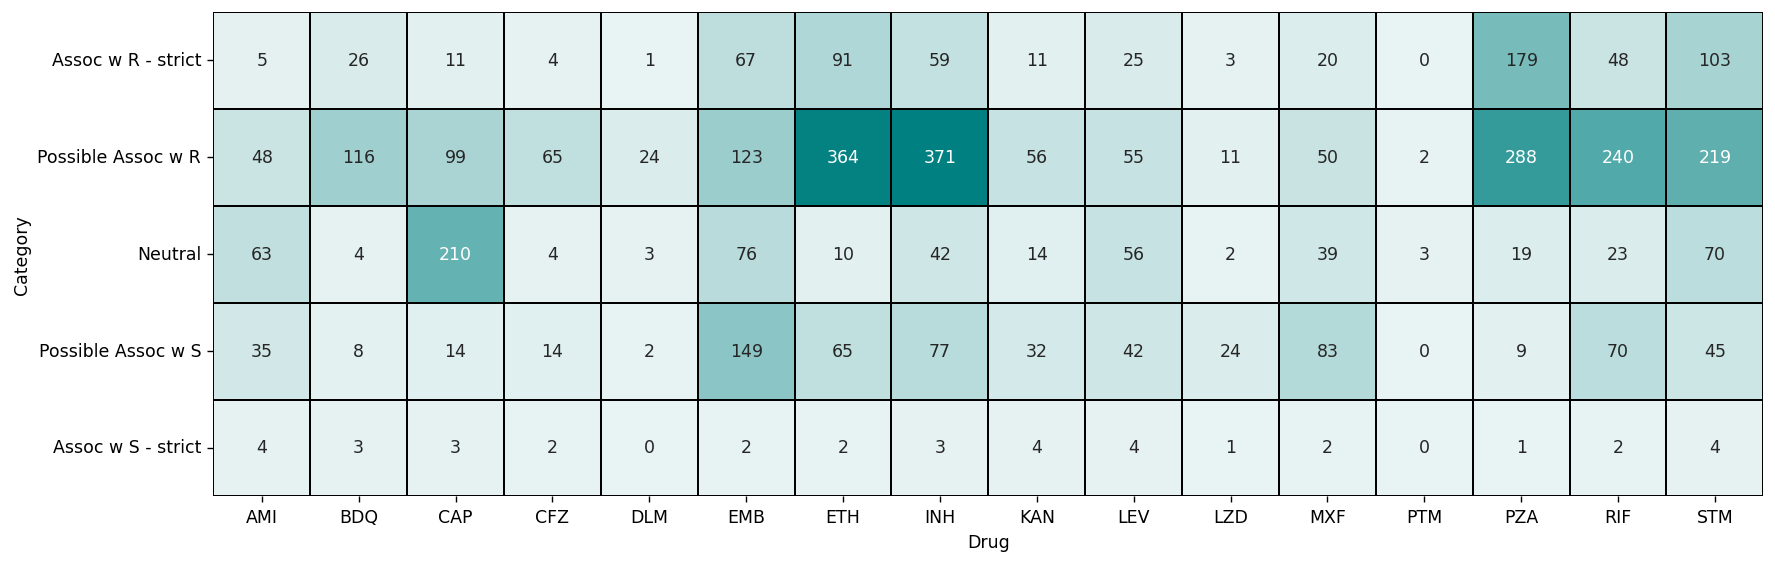

In [23]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.heatmap(
            data=summary_df_matrix.loc[["Assoc w R - strict", "Possible Assoc w R", "Neutral", "Possible Assoc w S", "Assoc w S - strict"], :],
            #data=summary_df_matrix.loc[["Assoc w R - strict", "Possible Assoc w R", "Neutral", "Possible Assoc w S", "Assoc w S - strict", "Uncertain"], :],
            cmap=sns.light_palette("teal", as_cmap=True),
            vmin=0,
            # vmax=1,
            cbar=False,
            square=True,
            annot=True,
            fmt='g',
            xticklabels=[drug_abbr_dict[val] for val in summary_df_matrix.columns],
            linewidths=1, 
            linecolor='black',
            ax=ax
           )

#plt.title("Counts of Tier 1 and 2 Mutations in ALL Phenotypes Models, Excluding Uncertain")
plt.savefig("category_counts_heatmap_without_uncertain.png", dpi=400)

# Overall Model AUC/Sens/Spec/Accuracy

In [73]:
binary_stats_analyses_lst = [path for path in binary_analyses_lst if "poolALL" not in path]
ptm_analyses_lst = [path for path in binary_stats_analyses_lst if "1+2" not in path and "WHO" not in path]

len(binary_stats_analyses_lst), len(ptm_analyses_lst)

(12, 3)

In [112]:
finished_drugs = []

for drug in np.sort(drugs_lst):
    
    found_all = 0
    
    if drug == "Pretomanid":
        search_lst = np.copy(ptm_analyses_lst)
    else:
        search_lst = np.copy(binary_stats_analyses_lst)
    
    for model_path in search_lst:
        
        if os.path.isfile(os.path.join(analysis_dir, drug, "BINARY", model_path, "model_stats_with_bootstrap.csv")):
            found_all += 1
            
    if found_all == len(search_lst):
        print(f"Finished {drug}!")
        finished_drugs.append(drug)

Finished Amikacin!
Finished Bedaquiline!
Finished Capreomycin!
Finished Clofazimine!
Finished Delamanid!
Finished Ethambutol!
Finished Ethionamide!
Finished Isoniazid!
Finished Kanamycin!
Finished Levofloxacin!
Finished Linezolid!
Finished Moxifloxacin!
Finished Pretomanid!
Finished Pyrazinamide!
Finished Rifampicin!
Finished Streptomycin!


# MIC Analyses

In [268]:
# # hard coded paths to preserve the model hierarchy
# mic_analyses_lst = ["tiers=1/dropAF_noSyn_poolSeparate",
#                     "tiers=1/dropAF_noSyn_unpooled",
#                     "tiers=1+2/dropAF_noSyn_poolSeparate",
#                     "tiers=1+2/dropAF_noSyn_unpooled",
#                    ]

# export_binary_mic_analyses(drugs_lst, "MIC", mic_analyses_lst)

# Binary Analysis Summaries File

## Make an Excel file summarizing the results for each drug for the binary analyses

## Break down results by FDR (Significant), OR > 1, Primary Analysis, PPV ≥ 25%, and True Positive (# with variant and resistant) ≥ 5

In [269]:
# def generate_summary_data(drug, folder):
    
#     # read in Excel file with all the sheets 
#     df = pd.read_excel(f"../results/{folder}/{drug}.xlsx", sheet_name=None)

#     # combine sheets into a single dataframe and keep only the first instance of every mutation
#     df = pd.concat(list(df.values())).drop_duplicates("mutation", keep="first")

#     # OR > 1 or OR < 1 --> associated with resistance or susceptibility
#     df["OR>1"] = (df["Odds_Ratio"] > 1)
#     df["PPV_LB≥0.25"] = (df["PPV_LB"] >= 0.25)
#     df["TP≥5"] = (df["TP"] >= 5)

#     df[["OR>1", "PPV_LB≥0.25", "TP≥5"]] = df[["OR>1", "PPV_LB≥0.25", "TP≥5"]].fillna(0).astype(int)
#     df["pooled"] = [0 if "unpooled" in val else 1 for val in df["pool_type"].values]

#     summary_cols = ["OR>1", "PPV_LB≥0.25", "TP≥5", "Significant", "Tier", "Phenos", "synonymous", "pooled"]
#     summary = pd.DataFrame(df[summary_cols].value_counts()).reset_index().rename(columns={0:"Count"})
#     summary = summary[["Count"] + summary_cols].sort_values(by=summary_cols, ascending=[False, False, False, False, True, False, True, True])

#     summary.loc[(summary["OR>1"] == 1) & 
#                 (summary["PPV_LB≥0.25"] == 1) &
#                 (summary["TP≥5"] == 1), "Expert_PASS"
#                 ] = 1

#     summary["Expert_PASS"] = summary["Expert_PASS"].fillna(0).astype(int)

#     return summary.rename(columns={"Tier": "Gene_Tier", "pooled": "LOF_inframe_pooling"}).reset_index(drop=True)

In [270]:
# analysis_summaries = {}
# folder = "BINARY"

# for drug in np.sort(drugs_lst):
    
#     if os.path.isfile(f"../results/{folder}/{drug}.xlsx"):
#         analysis_summaries[drug] = generate_summary_data(drug, folder)
    
# # write results to an Excel file, where each sheet name is a drug
# with pd.ExcelWriter("../results/ALLDrugs_summaries.xlsx") as file:
   
#     for key, val in analysis_summaries.items():
#         val.to_excel(file, sheet_name=key, index=False)

# CC vs. CC-ATU Analyses

Export only variants that would pass the Expert rule:

<ul>
    <li>Odds Ratio > 1</li>
    <li>N_resistant (i.e. true positive) ≥ 5</li>
    <li>PPV_LB ≥ 0.25</li>
    <li>Benjamini-Hochberg p-value < 0.01</li>
</ul>

In [110]:
# def export_cc_atu_analyses(drugs_lst, pval_thresh=0.01):
#     '''
#     This function combines the CC and CC-ATU analyses for each drug. 
#     '''
    
#     if not os.path.isdir("../results/ATU"):
#         os.mkdir("../results/ATU")
    
#     # hard coded paths to preserve the model hierarchy
#     analysis_paths = ["tiers=1/dropAF_noSyn_poolSeparate",
#                       "tiers=1/dropAF_noSyn_poolALL",
#                       "tiers=1/dropAF_noSyn_unpooled",
#                       "tiers=1+2/dropAF_noSyn_poolSeparate",
#                       "tiers=1+2/dropAF_noSyn_poolALL",
#                       "tiers=1+2/dropAF_noSyn_unpooled",
#     ]
    
#     for drug in drugs_lst:
        
#         all_analyses = {}
        
#         for i, model_path in enumerate(analysis_paths):

#             if os.path.isfile(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC.csv")):
            
#                 cc = pd.read_csv(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC.csv"))
#                 cc_atu = pd.read_csv(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC_ATU.csv"))

#                 cc.loc[(cc["Odds_Ratio"] > 1) & 
#                        (cc["TP"] >= 5) &
#                        (cc["PPV_LB"] >= 0.25) & 
#                        (cc["BH_pval"] < pval_thresh), "Expert_PASS"
#                       ] = 1

#                 cc_atu.loc[(cc_atu["Odds_Ratio"] > 1) & 
#                            (cc_atu["TP"] >= 5) &
#                            (cc_atu["PPV_LB"] >= 0.25) & 
#                            (cc_atu["BH_pval"] < pval_thresh), "Expert_PASS"
#                           ] = 1

#                 cc["ATU"] = 0
#                 cc_atu["ATU"] = 1

#                 combined_df = pd.concat([cc.query("Expert_PASS == 1"), cc_atu.query("Expert_PASS == 1")])
#                 del combined_df["Expert_PASS"]
                
#                 combined_df["Tier"] = [2 if "+2" in model_path else 1][0]
#                 combined_df["Phenos"] = ["ALL" if "ALL" in model_path else "WHO"][0]
#                 combined_df["pool_type"] = model_path.split("_")[-1]
#                 combined_df["synonymous"] = int("withSyn" in model_path)
#                 combined_df["HET"] = ["DROP" if "drop" in model_path else "AF"][0]

#                 # remove principal components
#                 combined_df = combined_df.loc[~combined_df["mutation"].str.contains("PC", case=True)]
            
#                 all_analyses[f"Model_{i+1}"] = combined_df.sort_values("Odds_Ratio", ascending=False)

#         if len(all_analyses) > 0:
                
#             with pd.ExcelWriter(f"../results/ATU/{drug}.xlsx") as file:

#                 for key, val in all_analyses.items():
#                     val.to_excel(file, sheet_name=key, index=False)
                  
#             print(f"Finished {drug}!")

In [111]:
# export_cc_atu_analyses(drugs_lst)

# Volcano Plots

In [37]:
def volcano_plot(drug, folder, plot_x, pval_col="BH_pval", color_col="Phenos", saveFig=None):
    '''
    This function generates a volcano scatterplot of p-values against odds ratios to visualize the results for each drug. 
    
    It generates 2 plots for each drug: one for the primary analyses and another for the additional variants picked up by the secondary analyses. Separating them makes the secondary results
    easier to see because the effect sizes for those are much smaller, and they can get obscured by the primary analysis results. 
    
    Arguments:
    
        df = dataframe of results
        plot_x = column in df to plot as the x variable
        plot_y = column in df to plot as the y variable
        pval_col = p-value column to plot (i.e. p-value, Bonferroni, or Benjamini-Hochberg)
        drug = drug name for plotting
        color_col = column in df to color point by. Default is Significant
        or_thresh = to clean up the plot, you can exclude some mutations with very small effect sizes. or_thresh should be a value in [0, ∞). i.e. a threshold of 0.01 will
                    exclude variants with odds ratios in [0.99, 1.01]
        save_fig = file name to save plot to. If it is None, the plot is rendered in the notebook.
        
    Primary analysis: Tier = 1, Phenos = WHO, unpooled = False, synonymous = False, HET mutations = DROP
    
    The function computes the log odds ratio, negative logarithm of p-values, and the logarithm of the negative log of p-values. 
    It plots the logarithm of the negative log of p-values vs. the coefficient in regression (linear or logistic). The log of the logistic regression coefficient is the log-Odds
    '''
    
    # read in Excel file with all the sheets 
    fName = f"../results/{folder}/{drug}.xlsx"
    
    if os.path.isfile(fName):
        
        # plot only unpooled mutation restuls
        if drug == "Pretomanid":
            df = pd.read_excel(fName, sheet_name=["Model_11"])
        else:
            df = pd.read_excel(fName, sheet_name=["Model_3", "Model_7", "Model_11", "Model_15"])

        # combine sheets into a single dataframe and keep only the first instance of every mutation
        df = pd.concat([single_df.loc[~pd.isnull(single_df["Odds_Ratio"])] for single_df in df.values()], axis=0)

        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        plot_df = df.copy()

        # add color categories
        plot_df.loc[(plot_df["Phenos"] == "WHO") & (plot_df["Tier"]==1) & (plot_df[pval_col] < 0.05), "color_col"] = "WHO"
        plot_df.loc[(plot_df["Phenos"] == "WHO") & (plot_df["Tier"]==2) & (plot_df[pval_col] < 0.01), "color_col"] = "WHO"

        plot_df.loc[(plot_df["Phenos"] == "ALL") & (plot_df["Tier"]==1) & (plot_df[pval_col] < 0.05), "color_col"] = "ALL"
        plot_df.loc[(plot_df["Phenos"] == "ALL") & (plot_df["Tier"]==2) & (plot_df[pval_col] < 0.01), "color_col"] = "ALL"

        # the remaining are insignificant
        plot_df["color_col"] = plot_df["color_col"].fillna("NOT")

        if plot_df[pval_col].min() == 0:
            second_smallest = np.sort(np.unique(plot_df[pval_col]))[1]
            plot_df[pval_col] += second_smallest

        plot_df[f"neg_log_{pval_col}"] = -np.log(plot_df[pval_col])
        plot_df[f"log_neg_log_{pval_col}"] = np.log(plot_df[f"neg_log_{pval_col}"])
        color_palette = {"WHO":sns.color_palette("tab10").as_hex()[0], "ALL":sns.color_palette("tab10").as_hex()[1], "NOT":"lightgray"}

        if plot_x == "coef":
            plot_df["coef"] = np.log(plot_df["Odds_Ratio"])
        plot_y = f"log_neg_log_{pval_col}"

        sns.scatterplot(data=plot_df.query("Tier==1"), 
                        x=plot_x, 
                        y=plot_y, 
                        alpha=0.8,
                        hue="color_col", 
                        linewidth=0.25,
                        edgecolor='white',
                        s=30,
                        palette=color_palette,
                        ax=ax[0]
                       )

        sns.scatterplot(data=plot_df.query("Tier==2"), 
                        x=plot_x, 
                        y=plot_y, 
                        alpha=0.8,
                        hue="color_col",
                        linewidth=0.25,
                        edgecolor='white',
                        s=30,
                        palette=color_palette,
                        ax=ax[1]
                       )

        
        if plot_x == "coef":
            baseline = 0
        else:
            baseline = 1
            
        bound_0 = np.max(np.abs(plot_df.query("Tier==1")[plot_x]))*1.1
        ax[0].set_xlim(baseline - (bound_0-baseline), baseline + (bound_0-baseline))
        ax[0].legend(title='')
        ax[0].set_title(f'''Tier 1: {len(plot_df.query("Tier==1 & color_col != 'NOT'"))} Mutations Significant in Ridge''')

        if drug != "Pretomanid":
            bound_1 = np.max(np.abs(plot_df.query("Tier==2")[plot_x]))*1.1
            ax[1].set_xlim(baseline - (bound_1-baseline), baseline + (bound_1-baseline))
            ax[1].legend(title='')
            ax[1].set_title(f'''Tier 2: {len(plot_df.query("Tier==2 & color_col != 'NOT'"))} Mutations Significant in Ridge''')

        sns.despine()

        if saveFig is not None:
            if not os.path.isdir(os.path.dirname(saveFig)):
                os.makedir(os.path.dirname(saveFig))
            plt.savefig(saveFig, dpi=300, bbox_inches="tight")
        else:
            plt.show()

        # return plot_df

In [38]:
def volcano_plot_by_significance(drug, color_dict, plot_x="coef", pval_col="AUC_BH_pval", saveFig=None):
    '''
    This function generates a volcano scatterplot of p-values against odds ratios to visualize the results for each drug. 
    
    It generates 2 plots for each drug: one for the primary analyses and another for the additional variants picked up by the secondary analyses. Separating them makes the secondary results
    easier to see because the effect sizes for those are much smaller, and they can get obscured by the primary analysis results. 
    
    Arguments:
    
        df = dataframe of results
        plot_x = column in df to plot as the x variable
        plot_y = column in df to plot as the y variable
        pval_col = p-value column to plot (i.e. p-value, Bonferroni, or Benjamini-Hochberg)
        drug = drug name for plotting
        color_col = column in df to color point by. Default is Significant
        or_thresh = to clean up the plot, you can exclude some mutations with very small effect sizes. or_thresh should be a value in [0, ∞). i.e. a threshold of 0.01 will
                    exclude variants with odds ratios in [0.99, 1.01]
        save_fig = file name to save plot to. If it is None, the plot is rendered in the notebook.
        
    Primary analysis: Tier = 1, Phenos = WHO, unpooled = False, synonymous = False, HET mutations = DROP
    
    The function computes the log odds ratio, negative logarithm of p-values, and the logarithm of the negative log of p-values. 
    It plots the logarithm of the negative log of p-values vs. the coefficient in regression (linear or logistic). The log of the logistic regression coefficient is the log-Odds
    '''
    
    model_lst =  ["Model_3", "Model_7", "Model_11", "Model_15"]
    dfs_lst = []

    for key, df in full_results_dict[drug].items():
        if key in model_lst:
            dfs_lst.append(df.loc[~pd.isnull(df["Odds_Ratio"])])

    plot_df = pd.concat(dfs_lst, axis=0)

    if plot_df[pval_col].min() == 0:
        second_smallest = np.sort(np.unique(plot_df[pval_col]))[1]
        plot_df[pval_col] += second_smallest

    plot_df[f"neg_log_{pval_col}"] = -np.log(plot_df[pval_col])
    plot_df[f"log_neg_log_{pval_col}"] = np.log(plot_df[f"neg_log_{pval_col}"])
    
#     groups = ["1) Assoc w R", "2) Assoc w R - Interim", "3) Uncertain", "4) Assoc w S - Interim", "5) Assoc w S", "6) No Assoc"]
#     names = ["Assoc w R", "Assoc w R-Interim", "Uncertain", "Assoc w S-Interim", "Assoc w S", "No Assoc"]

#     plot_df["regression_confidence"] = plot_df["regression_confidence"].map(dict(zip(groups, names)))
    
    
    # categories = ["Evidence against Assoc", "Assoc w S", "Assoc w R", "Assoc w S - strict", "Assoc w R - strict"]
    # color_palette = dict(zip(categories, sns.color_palette("colorblind").as_hex()[:len(categories)]))
    # color_palette["Evidence against Assoc"] = "lightgray"
    
    plot_df["regression_confidence"] = plot_df["regression_confidence"].replace("Assoc w R - strict", "5").replace("Assoc w S - strict", "4")
    
    # lots of overlap between WHO and ALL groups, so don't double plot. Keep first (WHO)
    plot_df = plot_df.sort_values("regression_confidence", ascending=False).drop_duplicates("mutation", keep="last")
    plot_df["regression_confidence"] = plot_df["regression_confidence"].replace("5", "Assoc w R - strict").replace("4", "Assoc w S - strict").replace("Evidence against Assoc", "No Assoc")
    
    if plot_x == "coef":
        plot_df["coef"] = np.log(plot_df["Odds_Ratio"])
            
    plot_y = f"log_neg_log_{pval_col}"
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.scatterplot(data=plot_df.query("Tier==1"), 
                    x=plot_x, 
                    y=plot_y, 
                    alpha=1,
                    hue="regression_confidence", 
                    linewidth=0.25,
                    edgecolor='white',
                    s=30,
                    palette=color_dict,
                    ax=ax[0]
                   )

    sns.scatterplot(data=plot_df.query("Tier==2"), 
                    x=plot_x, 
                    y=plot_y, 
                    alpha=1,
                    hue="regression_confidence",
                    linewidth=0.25,
                    edgecolor='white',
                    s=30,
                    palette=color_dict,
                    ax=ax[1]
                   )

    if plot_x == "coef":
        baseline = 0
    else:
        baseline = 1
        
    try:
        bound_0 = np.max(np.abs(plot_df.query("Tier==1")[plot_x]))*1.1
        ax[0].set_xlim(baseline - (bound_0-baseline), baseline + (bound_0-baseline))
        ax[0].legend(title='')
        
        bound_1 = np.max(np.abs(plot_df.query("Tier==2")[plot_x]))*1.1
        ax[1].set_xlim(baseline - (bound_1-baseline), baseline + (bound_1-baseline))
        ax[1].get_legend().remove()
    except:
        pass

    ax[0].set_title(f"{drug}, Tier 1")
    ax[1].set_title(f"{drug}, Tier 2")
    
    sns.despine()

    if saveFig is not None:
        if not os.path.isdir(os.path.dirname(saveFig)):
            os.makedir(os.path.dirname(saveFig))
        plt.savefig(saveFig, dpi=300, bbox_inches="tight")
    else:
        plt.show()

In [39]:
# https://imagecolorpicker.com/en

color_dict = {"Assoc w R - strict": "#c34a4f",
              "Assoc w R": "#e2a19e",
              "Assoc w S - strict": "#2b79c4",
              "Assoc w S": "#acbdd4",
              "No Assoc": "lightgray"
             }

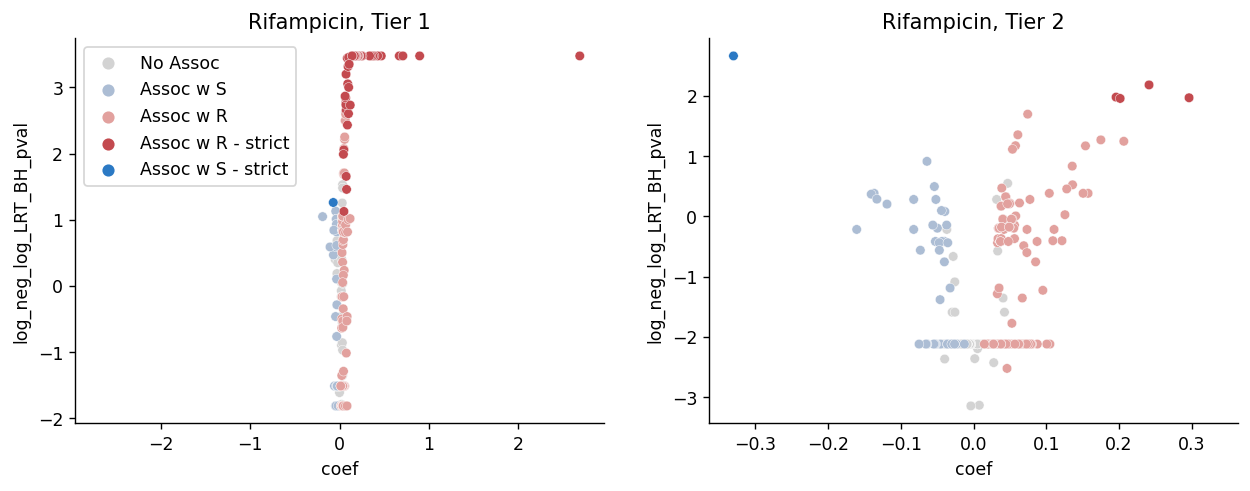

In [41]:
volcano_plot_by_significance("Rifampicin", color_dict, pval_col="LRT_BH_pval", saveFig="../results/Figures/RIF_volcano.png")

In [203]:
# for drug in np.sort(drugs_lst):
#     try:
#         volcano_plot_by_significance(drug, color_dict, pval_col="LRT_BH_pval")
#     except:
#         print(drug)

In [194]:
drug = "Rifampicin"
model_lst =  ["Model_3", "Model_7", "Model_11", "Model_15"]
dfs_lst = []

for key, df in full_results_dict[drug].items():
    if key in model_lst:
        dfs_lst.append(df.loc[~pd.isnull(df["Odds_Ratio"])])

# lots of overlap between WHO and ALL groups, so don't double plot. Keep first (WHO)
plot_df = pd.concat(dfs_lst, axis=0)#.drop_duplicates("mutation", keep="first")

In [197]:
plot_df.drop_duplicates("mutation", keep="first").query("Tier==2 & regression_confidence=='Assoc w R - strict'")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
2,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.216332,1.139563,1.296843,0.0,0.0,...,0.955703,3.348102,3.887383,0.862922,0.879198,Assoc w R - strict,0.0,WHO,unpooled,0.0


In [207]:
plot_df.drop_duplicates(["mutation", "Tier"], keep="first").query("Tier==2 & regression_confidence=='Assoc w R - strict'")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
2,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.216332,1.139563,1.296843,0.0,0.0,...,0.955703,3.348102,3.887383,0.862922,0.879198,Assoc w R - strict,0.0,WHO,unpooled,0.0


In [211]:
plot_df.query("mutation=='rpoC_p.Val483Gly'").sort_values("regression_confidence", ascending=False)

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
0,rpoC_p.Val483Gly,2.0,missense_variant,764817,NaN,1.344718,1.242714,1.460296,0.0,0.0,...,0.999489,58.482994,135.908209,0.923942,0.932313,Assoc w R - strict,0.0,ALL,unpooled,0.0
0,rpoC_p.Val483Gly,2.0,missense_variant,764817,NaN,1.351136,1.251374,1.477266,0.0,0.0,...,0.999527,66.864897,174.395519,0.907468,0.918555,Assoc w R,0.0,WHO,unpooled,0.0


In [213]:
plot_df.drop_duplicates("regression_confidence").sort_values("regression_confidence", ascending=False)

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
73,rpoB_p.Asp435Asn,1.0,missense_variant,761109,NaN,1.047448,1.021614,1.066732,0.014,0.069157,...,1.00000,NaN,inf,0.999311,0.999993,Evidence against Assoc,0.0,WHO,unpooled,0.0
745,rpoB_p.Gln436Asn,1.0,missense_variant,761108;761112,2) Assoc w R - Interim,0.981597,0.964968,1.000000,0.000,0.000000,...,1.00000,NaN,inf,0.999876,1.000040,Assoc w S,0.0,WHO,unpooled,0.0
0,rpoB_p.Ser450Leu,1.0,missense_variant,761154;761155,1) Assoc w R,13.996830,13.450316,14.703059,0.000,0.000000,...,0.99674,131.630401,196.405333,0.345859,0.363410,Assoc w R - strict,1.0,WHO,unpooled,0.0
23,rpoB_p.Pro45Ser,1.0,missense_variant,759939,3) Uncertain significance,1.138876,1.054409,1.192612,0.000,0.000000,...,1.00000,NaN,inf,0.995346,0.997525,Assoc w R,0.0,WHO,unpooled,0.0


In [208]:
plot_df.query("Tier==2 & regression_confidence=='Assoc w R - strict'")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
2,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.216332,1.139563,1.296843,0.0,0.0,...,0.955703,3.348102,3.887383,0.862922,0.879198,Assoc w R - strict,0.0,WHO,unpooled,0.0
0,rpoC_p.Val483Gly,2.0,missense_variant,764817,NaN,1.344718,1.242714,1.460296,0.0,0.0,...,0.999489,58.482994,135.908209,0.923942,0.932313,Assoc w R - strict,0.0,ALL,unpooled,0.0
1,rpoC_p.Val483Ala,2.0,missense_variant,764817,NaN,1.272722,1.183928,1.382687,0.0,0.0,...,0.999848,50.269027,187.835571,0.965086,0.970792,Assoc w R - strict,0.0,ALL,unpooled,0.0
3,rpoC_p.Asn698Ser,2.0,missense_variant,765462,NaN,1.223164,1.156612,1.275521,0.0,0.0,...,1.000000,NaN,inf,0.987087,0.990472,Assoc w R - strict,0.0,ALL,unpooled,0.0
5,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.175690,1.116430,1.247490,0.0,0.0,...,0.960689,2.866597,3.303348,0.903668,0.915757,Assoc w R - strict,0.0,ALL,unpooled,0.0


In [165]:
# volcano_plot("Delamanid", "BINARY", "coef")

In [193]:
for drug in drugs_lst:
    if drug != "Isoniazid":
        for key, df in full_results_dict[drug].items():
            if "_3" in key or "_7" in key or "_11" in key or "_15" in key:
                if len(df.query("mutation.str.contains('Rv2752c') & regression_confidence != '6) No Assoc'")) > 0:
                    print(drug)

Levofloxacin
Levofloxacin
Ethambutol
Ethambutol
Moxifloxacin
Moxifloxacin
Rifampicin
Rifampicin


In [171]:
len(set(full_results_dict["Rifampicin"]["Model_3"].query("High_Predictive_Value==1").mutation).union(full_results_dict["Rifampicin"]["Model_11"].query("High_Predictive_Value==1").mutation))

25

In [183]:
len(set(full_results_dict["Rifampicin"]["Model_3"].query("regression_confidence=='Assoc w R - strict'").mutation).union(full_results_dict["Rifampicin"]["Model_11"].query("regression_confidence=='Assoc w R - strict'").mutation))

44

In [184]:
summary_dfs_dict["Rifampicin"]

,"Tier1,WHO","Tier2,WHO","Tier1,ALL","Tier2,ALL"
regression_confidence,,,,
Assoc w R,91,103,112,128
Assoc w R - strict,39,1,44,4
Assoc w S,24,40,25,47
Assoc w S - strict,0,0,0,0
Evidence against Assoc,661,2701,769,3258


In [186]:
full_results_dict["Rifampicin"]["Model_7"].query("regression_confidence=='Assoc w R - strict'")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
2,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.216332,1.139563,1.296843,0.0,0.0,...,0.955703,3.348102,3.887383,0.862922,0.879198,Assoc w R - strict,0.0,WHO,unpooled,0.0


In [190]:
for mut in full_results_dict["Rifampicin"]["Model_15"].query("regression_confidence=='Assoc w R - strict'").mutation.values:
    print(mut)

rpoC_p.Val483Gly
rpoC_p.Val483Ala
rpoC_p.Asn698Ser
rpoC_p.Glu1092Asp


In [202]:
full_results_dict["Rifampicin"]["Model_7"].query("regression_confidence=='Assoc w R - strict'")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
2,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.216332,1.139563,1.296843,0.0,0.0,...,0.955703,3.348102,3.887383,0.862922,0.879198,Assoc w R - strict,0.0,WHO,unpooled,0.0


,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
0,rpoC_p.Val483Gly,2.0,missense_variant,764817,NaN,1.344718,1.242714,1.460296,0.0,0.0,...,0.999489,58.482994,135.908209,0.923942,0.932313,Assoc w R - strict,0.0,ALL,unpooled,0.0
1,rpoC_p.Val483Ala,2.0,missense_variant,764817,NaN,1.272722,1.183928,1.382687,0.0,0.0,...,0.999848,50.269027,187.835571,0.965086,0.970792,Assoc w R - strict,0.0,ALL,unpooled,0.0
3,rpoC_p.Asn698Ser,2.0,missense_variant,765462,NaN,1.223164,1.156612,1.275521,0.0,0.0,...,1.000000,NaN,inf,0.987087,0.990472,Assoc w R - strict,0.0,ALL,unpooled,0.0
5,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.175690,1.116430,1.247490,0.0,0.0,...,0.960689,2.866597,3.303348,0.903668,0.915757,Assoc w R - strict,0.0,ALL,unpooled,0.0
